In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install mahotas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.7 MB 3.3 MB/s 


In [3]:
import numpy as np
import mahotas
import cv2
import os
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [4]:
import itertools

indexes = list(itertools.product([0,1,2,3,4,5,6,7],[0,1,2],[0,1,2]))
print(indexes)

[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 2, 0), (0, 2, 1), (0, 2, 2), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 2, 0), (1, 2, 1), (1, 2, 2), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 2, 0), (2, 2, 1), (2, 2, 2), (3, 0, 0), (3, 0, 1), (3, 0, 2), (3, 1, 0), (3, 1, 1), (3, 1, 2), (3, 2, 0), (3, 2, 1), (3, 2, 2), (4, 0, 0), (4, 0, 1), (4, 0, 2), (4, 1, 0), (4, 1, 1), (4, 1, 2), (4, 2, 0), (4, 2, 1), (4, 2, 2), (5, 0, 0), (5, 0, 1), (5, 0, 2), (5, 1, 0), (5, 1, 1), (5, 1, 2), (5, 2, 0), (5, 2, 1), (5, 2, 2), (6, 0, 0), (6, 0, 1), (6, 0, 2), (6, 1, 0), (6, 1, 1), (6, 1, 2), (6, 2, 0), (6, 2, 1), (6, 2, 2), (7, 0, 0), (7, 0, 1), (7, 0, 2), (7, 1, 0), (7, 1, 1), (7, 1, 2), (7, 2, 0), (7, 2, 1), (7, 2, 2)]


In [5]:
def normalize(values, bounds):
    return [bounds['desired']['lower'] + (x - bounds['actual']['lower']) * (bounds['desired']['upper'] - bounds['desired']['lower']) / (bounds['actual']['upper'] - bounds['actual']['lower']) for x in values]

In [6]:
def get_F(h, s, v):
    h_norm = normalize(
        h,
        {'actual': {'lower': 0, 'upper': 179}, 'desired': {'lower': 0, 'upper': 360}}
    )
    s_norm = normalize(
        s,
        {'actual': {'lower': 0, 'upper': 255}, 'desired': {'lower': 0, 'upper': 1}}
    )
    v_norm = normalize(
        v,
        {'actual': {'lower': 0, 'upper': 255}, 'desired': {'lower': 0, 'upper': 1}}
    )
    
    h_norm = np.array(h_norm).flatten()
    s_norm = np.array(s_norm).flatten()
    v_norm = np.array(v_norm).flatten()
    
    h_d = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0}
    s_d = {0:0, 1:0, 2:0}
    v_d = {0:0, 1:0, 2:0}

    for i in range(len(h_norm)):
        H = h_norm[i]
        ha = None
        if H >= 316 or H <= 20:
            ha = 0
        elif H >= 21 and H <= 40:
            ha = 1
        elif H >= 41 and H <= 75:
            ha = 2
        elif H >= 76 and H <= 155:
            ha = 3
        elif H >= 156 and H <= 190:
            ha = 4
        elif H >= 191 and H <= 270:
            ha = 5
        elif H >= 271 and H <= 295:
            ha = 6
        elif H >= 296 and H <= 315:
            ha = 7
        if ha not in h_d:
            h_d[ha] = 1
        else:
            h_d[ha] += 1

    for i in range(len(s_norm)):
        S = s_norm[i]
        sa = None
        if S >= 0 and S <= 0.2:
            sa = 0
        elif S > 0.2 and S <= 0.7:
            sa = 1
        elif S > 0.7 and S <= 1:
            sa = 2
        if sa not in s_d:
            s_d[sa] = 1
        else:
            s_d[sa] += 1

    for i in range(len(v_norm)):
        V = v_norm[i]
        va = None
        if V >= 0 and V <= 0.2:
            va = 0
        elif V > 0.2 and V <= 0.7:
            va = 1
        elif V > 0.7 and V <= 1:
            va = 2
        if va not in v_d:
            v_d[va] = 1
        else:
            v_d[va] += 1
            
    F = np.zeros((72,))
    
    for i in range(8):
        for j in range(3):
            for k in range(3):
                F[indexes.index((i, j, k))] = 9*h_d[i] + 3*s_d[j] + v_d[k]
    return F

In [28]:
def save_video(fname, key_frames):
    count = 0

    cur_dir = fname[0:-4]

    vidcap = cv2.VideoCapture(fname)
    success, img = vidcap.read()

    while success:
        if count in key_frames:
            print(f'{count} in key frame')
            plt.imshow(img)
            plt.show()
        success, img = vidcap.read()
        count += 1
    vidcap.release()

def process_video(fname):
    """
        Uses Zernik moments

    """
    colour_features = []

    vidcap = cv2.VideoCapture(fname)
    success, img = vidcap.read()

    count = 0
    while success:
        img3 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        """
        img2 = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        h, s, v = img2[:,:,0], img2[:,:,1], img2[:,:,2]
        F1 = get_F(h, s, v)
        thresh = cv2.threshold(img3, 50, 100, cv2.THRESH_BINARY)[1]
        F2 = np.append(mahotas.features.zernike_moments(thresh, 250), cv2.HuMoments(cv2.moments(img3)).flatten())
        

        colour_features.append(np.append(F1, F2))
        """
        img2 = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        h, s, v = img2[:,:,0], img2[:,:,1], img2[:,:,2]
        F1 = get_F(h, s, v)
        colour_features.append(np.append(np.real(np.fft.fft2(img3)).flatten(),F1))
        if(count%25 == 0):
            print(f"{count} images done")
            #print(F1.shape, F2.shape)
        success, img = vidcap.read()
        count += 1
    
    vidcap.release()
        
    best_i = 0
    best_sc = -1

    for i in range(8,9):
        kmeans = KMeans(n_clusters=i, random_state=0).fit(colour_features)
        sc = silhouette_score(colour_features, kmeans.labels_)
        if(sc > best_sc):
            best_i = i
            best_sc = sc
        #print(i, silhouette_score(colour_features, kmeans.labels_))

    print(f'Best silhouette score was {best_sc} for k value of {best_i}')

    kmeans = KMeans(n_clusters=best_i, random_state=0).fit(colour_features)
    cents = kmeans.cluster_centers_

    print(len(colour_features), len(kmeans.labels_))

    min_dict = {}
    min_frame= {}
    for i in range(len(kmeans.labels_)):
        t = np.linalg.norm(colour_features[i]-cents[kmeans.labels_[i]])
        if kmeans.labels_[i] not in min_dict:
            min_dict[kmeans.labels_[i]] = t
            min_frame[kmeans.labels_[i]] = i
        else:
            if(t < min_dict[kmeans.labels_[i]]):
                min_dict[kmeans.labels_[i]] = t
                min_frame[kmeans.labels_[i]] = i

    print(min_frame.values())

    key_frames = list(min_frame.values())

    save_video(fname, key_frames)


0 images done
25 images done
50 images done
75 images done
100 images done
125 images done
150 images done
Best silhouette score was 0.27078411397241164 for k value of 8
159 159
dict_values([8, 28, 52, 76, 94, 112, 136, 151])
8 in key frame


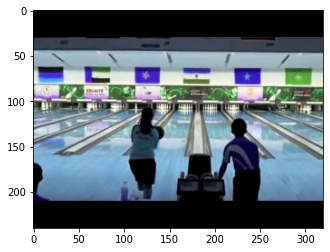

28 in key frame


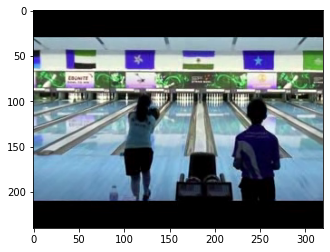

52 in key frame


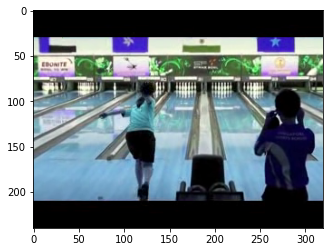

76 in key frame


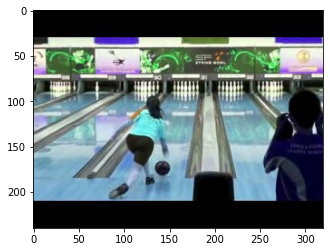

94 in key frame


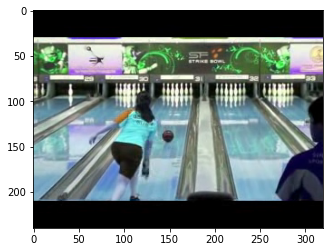

112 in key frame


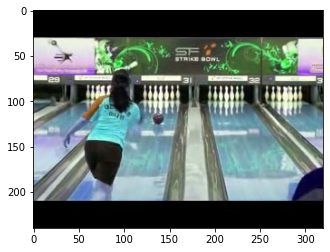

136 in key frame


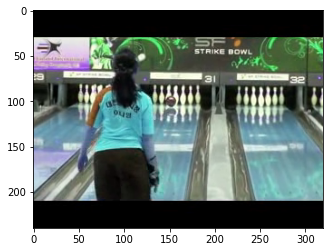

151 in key frame


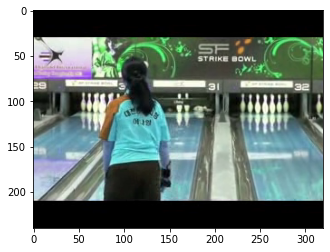

In [30]:
process_video("/content/drive/MyDrive/KeyFrame/Testing/vid1/ucf1.avi")